In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import numpy as np
import lineagevi as linvi
import torch

In [3]:
#adata = sc.read_h5ad('/Users/lgolinelli/git/lineageVI/notebooks/data/outputs/pancreas_2025.08.17_12.43.17/adata_with_velocity.h5ad')
adata = sc.read_h5ad('/Users/lgolinelli/git/lineageVI/notebooks/data/outputs/pancreas_2025.08.24_12.36.47/adata_with_velocity.h5ad')

In [5]:
model = linvi.trainer.LineageVI(
        adata,
        n_hidden=128,
        mask_key="I",
        gene_prior=True,
        unspliced_key="unspliced",
        spliced_key="spliced",
    )

#model_path = '/Users/lgolinelli/git/lineageVI/notebooks/data/outputs/pancreas_2025.08.17_12.43.17/vae_velocity_model.pt'
model_path = '/Users/lgolinelli/git/lineageVI/notebooks/data/outputs/pancreas_2025.08.24_12.36.47/vae_velocity_model.pt'
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()

LineageVI(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=1805, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
    )
    (mean_layer): Linear(in_features=128, out_features=647, bias=True)
    (logvar_layer): Linear(in_features=128, out_features=647, bias=True)
  )
  (gene_decoder): MaskedLinearDecoder(
    (linear): Linear(in_features=647, out_features=1805, bias=True)
  )
  (velocity_decoder): VelocityDecoder(
    (shared_decoder): Sequential(
      (0): Linear(in_features=647, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
    )
    (gp_velocity_decoder): Linear(in_features=128, out_features=647, bias=True)
    (gene_velocity_decoder): Sequential(
      (0): Linear(in_features=128, out_features=5415, bias=True)
      (1): Softplus(beta=1.0, threshold=20.0)
    )
  )
)

In [6]:
adata_gp = model.build_gp_adata()

In [7]:
adata.layers['velocity'] *=-1
adata.obsm['velocity_gp'] *=-1

In [8]:
from lineagevi.plotting import top_gps_table

top_gps_table(adata_gp, celltype_key="clusters", categories="all", layer="velocity", n=10)

,gp,mean_activation,Pre-endocrine mean,Ductal mean,Alpha mean,Ngn3 high EP mean,Delta mean,Beta mean,Ngn3 low EP mean,Epsilon mean
1,FETAL_INTESTINE_CHROMAFFIN_CEL,2.741670,3.085708,2.180694,3.138562,2.771967,3.002815,2.759664,2.605101,3.493061
2,REGULATION_OF_BETA_CELL_DEVELO,-2.709332,-2.980453,-1.814849,-3.854625,-1.726454,-3.885859,-4.032461,-1.974196,-3.182917
3,LUPUS_VS_HEALTHY_DONOR_BCELL_D,-2.685241,-2.996183,-1.643210,-3.913514,-1.762537,-4.025713,-4.096317,-1.778852,-3.260462
4,MATURITY_ONSET_DIABETES_OF_THE,-2.641557,-2.947305,-1.587676,-3.902562,-1.650735,-4.000581,-4.173191,-1.669173,-3.122968
5,TP53_TARGETS_DN,-2.553923,-2.938056,-1.440179,-3.782134,-1.675503,-3.842424,-3.937057,-1.656197,-3.212715
6,FETAL_PANCREAS_ISLET_ENDOCRINE,-2.552677,-2.684477,-2.190204,-2.999565,-2.383179,-2.902013,-2.528357,-2.649557,-3.344302
7,UNTREATED_VS_IL2_TREATED_CD8_T,2.517651,2.743383,1.593045,3.646551,1.636182,3.787378,3.927274,1.672961,2.767909
8,MAIN_FETAL_ISLET_ENDOCRINE_CEL,-2.430358,-2.685508,-1.447768,-3.668837,-1.456070,-3.776238,-3.850300,-1.556522,-2.953804
9,FETAL_STOMACH_NEUROENDOCRINE_C,2.388155,2.612557,2.014441,2.713116,2.280645,2.703200,2.414126,2.305644,3.137453
10,BRAIN_HCP_WITH_H3K27ME3,2.286979,2.421983,2.121241,2.397513,2.359809,2.311754,2.018625,2.566063,2.679337


In [9]:
top_gps_table(adata_gp, celltype_key="clusters", categories=["Ductal", 'Beta'], layer="velocity", n=30)

,gp,mean_activation,Ductal mean,Beta mean
1,REGULATION_OF_BETA_CELL_DEVELO,-2.684531,-1.814849,-4.032461
2,LUPUS_VS_HEALTHY_DONOR_BCELL_D,-2.605244,-1.643210,-4.096317
3,MATURITY_ONSET_DIABETES_OF_THE,-2.601637,-1.587676,-4.173191
4,UNTREATED_VS_IL2_TREATED_CD8_T,2.508463,1.593045,3.927274
5,TP53_TARGETS_DN,-2.419380,-1.440179,-3.937057
6,FETAL_INTESTINE_CHROMAFFIN_CEL,2.407749,2.180694,2.759664
7,MAIN_FETAL_ISLET_ENDOCRINE_CEL,-2.389969,-1.447768,-3.850300
8,FETAL_PANCREAS_ISLET_ENDOCRINE,-2.322817,-2.190204,-2.528357
9,RB1_TARGETS_UP,2.295200,1.463583,3.584124
10,FETAL_CEREBELLUM_VASCULAR_ENDO,-2.217869,-1.417220,-3.458802


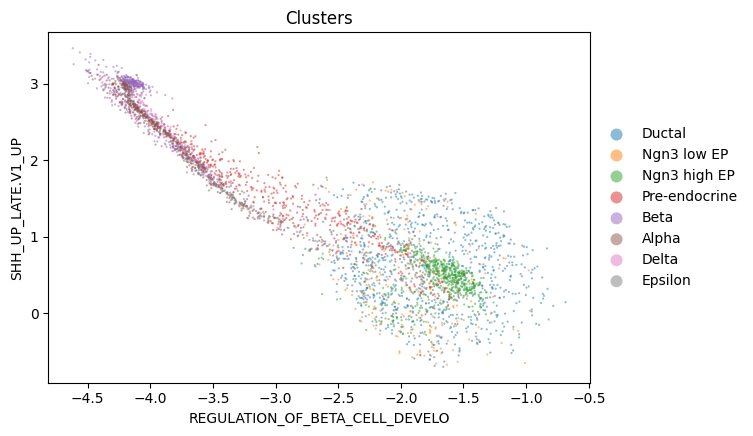

In [10]:
sc.pl.scatter(adata_gp, x='REGULATION_OF_BETA_CELL_DEVELO',y='SHH_UP_LATE.V1_UP', color='clusters', layers='velocity', size=10, alpha=0.5, title='Clusters')

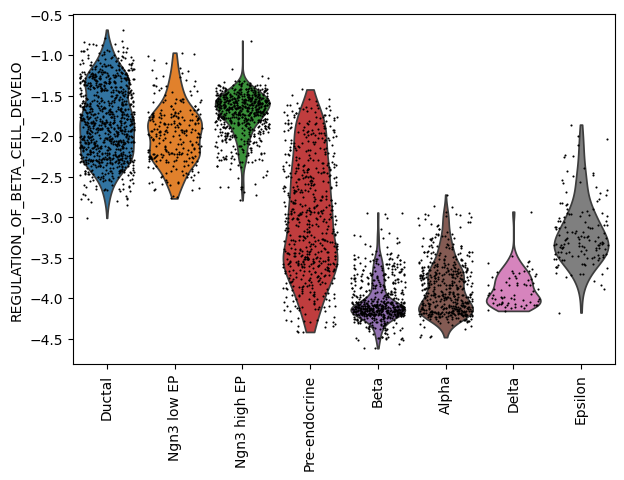

In [11]:
sc.pl.violin(adata_gp, keys="REGULATION_OF_BETA_CELL_DEVELO", layer='velocity', groupby="clusters", rotation=90, stripplot=True, jitter=0.4, size=1.5)

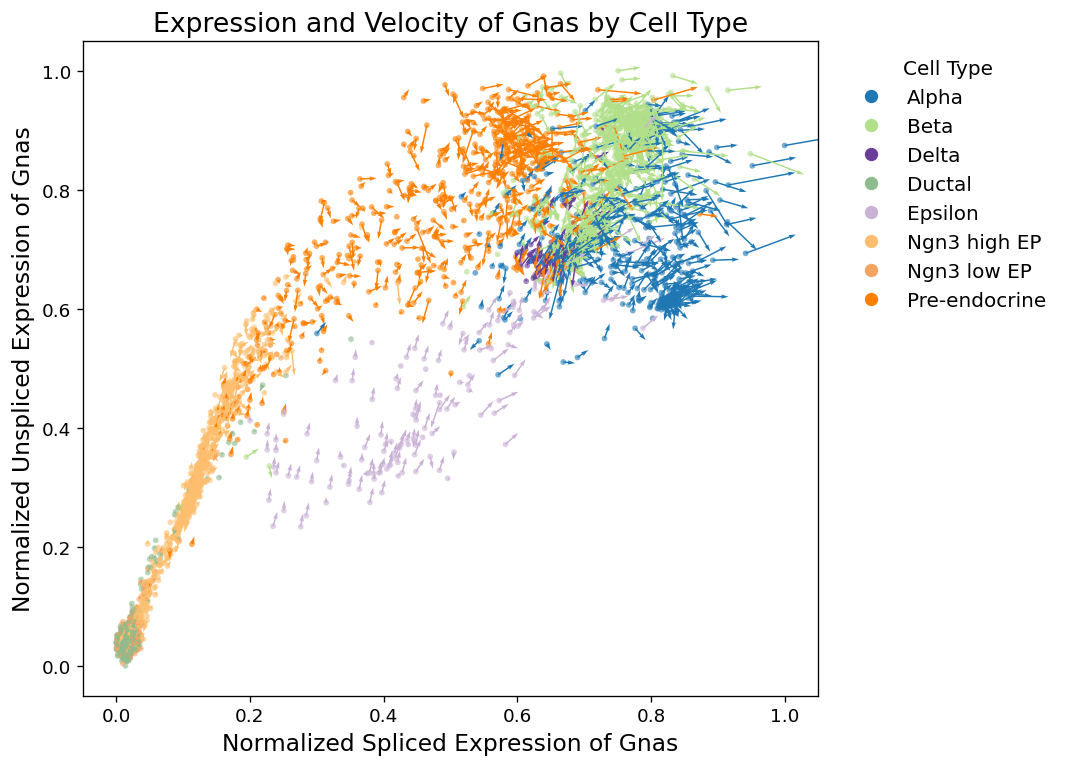

(<Figure size 1080x780 with 1 Axes>,
 <Axes: title={'center': 'Expression and Velocity of Gnas by Cell Type'}, xlabel='Normalized Spliced Expression of Gnas', ylabel='Normalized Unspliced Expression of Gnas'>)

In [12]:
from lineagevi.plotting import plot_phase_plane
plot_phase_plane(adata, 'Gnas', u_scale=.1, s_scale=.1, alpha=1, head_width=0.02, head_length=0.03, length_includes_head=False)

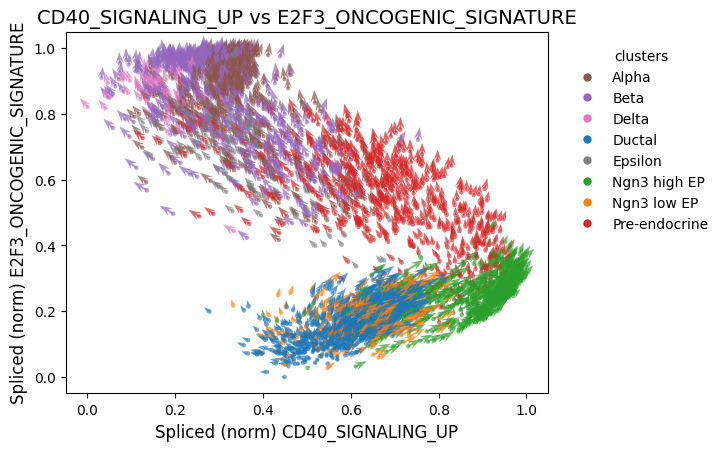

(<Figure size 1040x440 with 2 Axes>,
 array([[<Axes: title={'center': 'CD40_SIGNALING_UP vs E2F3_ONCOGENIC_SIGNATURE'}, xlabel='Spliced (norm) CD40_SIGNALING_UP', ylabel='Spliced (norm) E2F3_ONCOGENIC_SIGNATURE'>,
         <Axes: >]], dtype=object))

In [13]:
from lineagevi.plotting import plot_gp_phase_planes
plot_gp_phase_planes(adata_gp, program_pairs=[("CD40_SIGNALING_UP", "E2F3_ONCOGENIC_SIGNATURE")])

In [14]:
model.latent_enrich(adata, groups='clusters', comparison='rest', n_sample=5000, key_added='bf_scores')

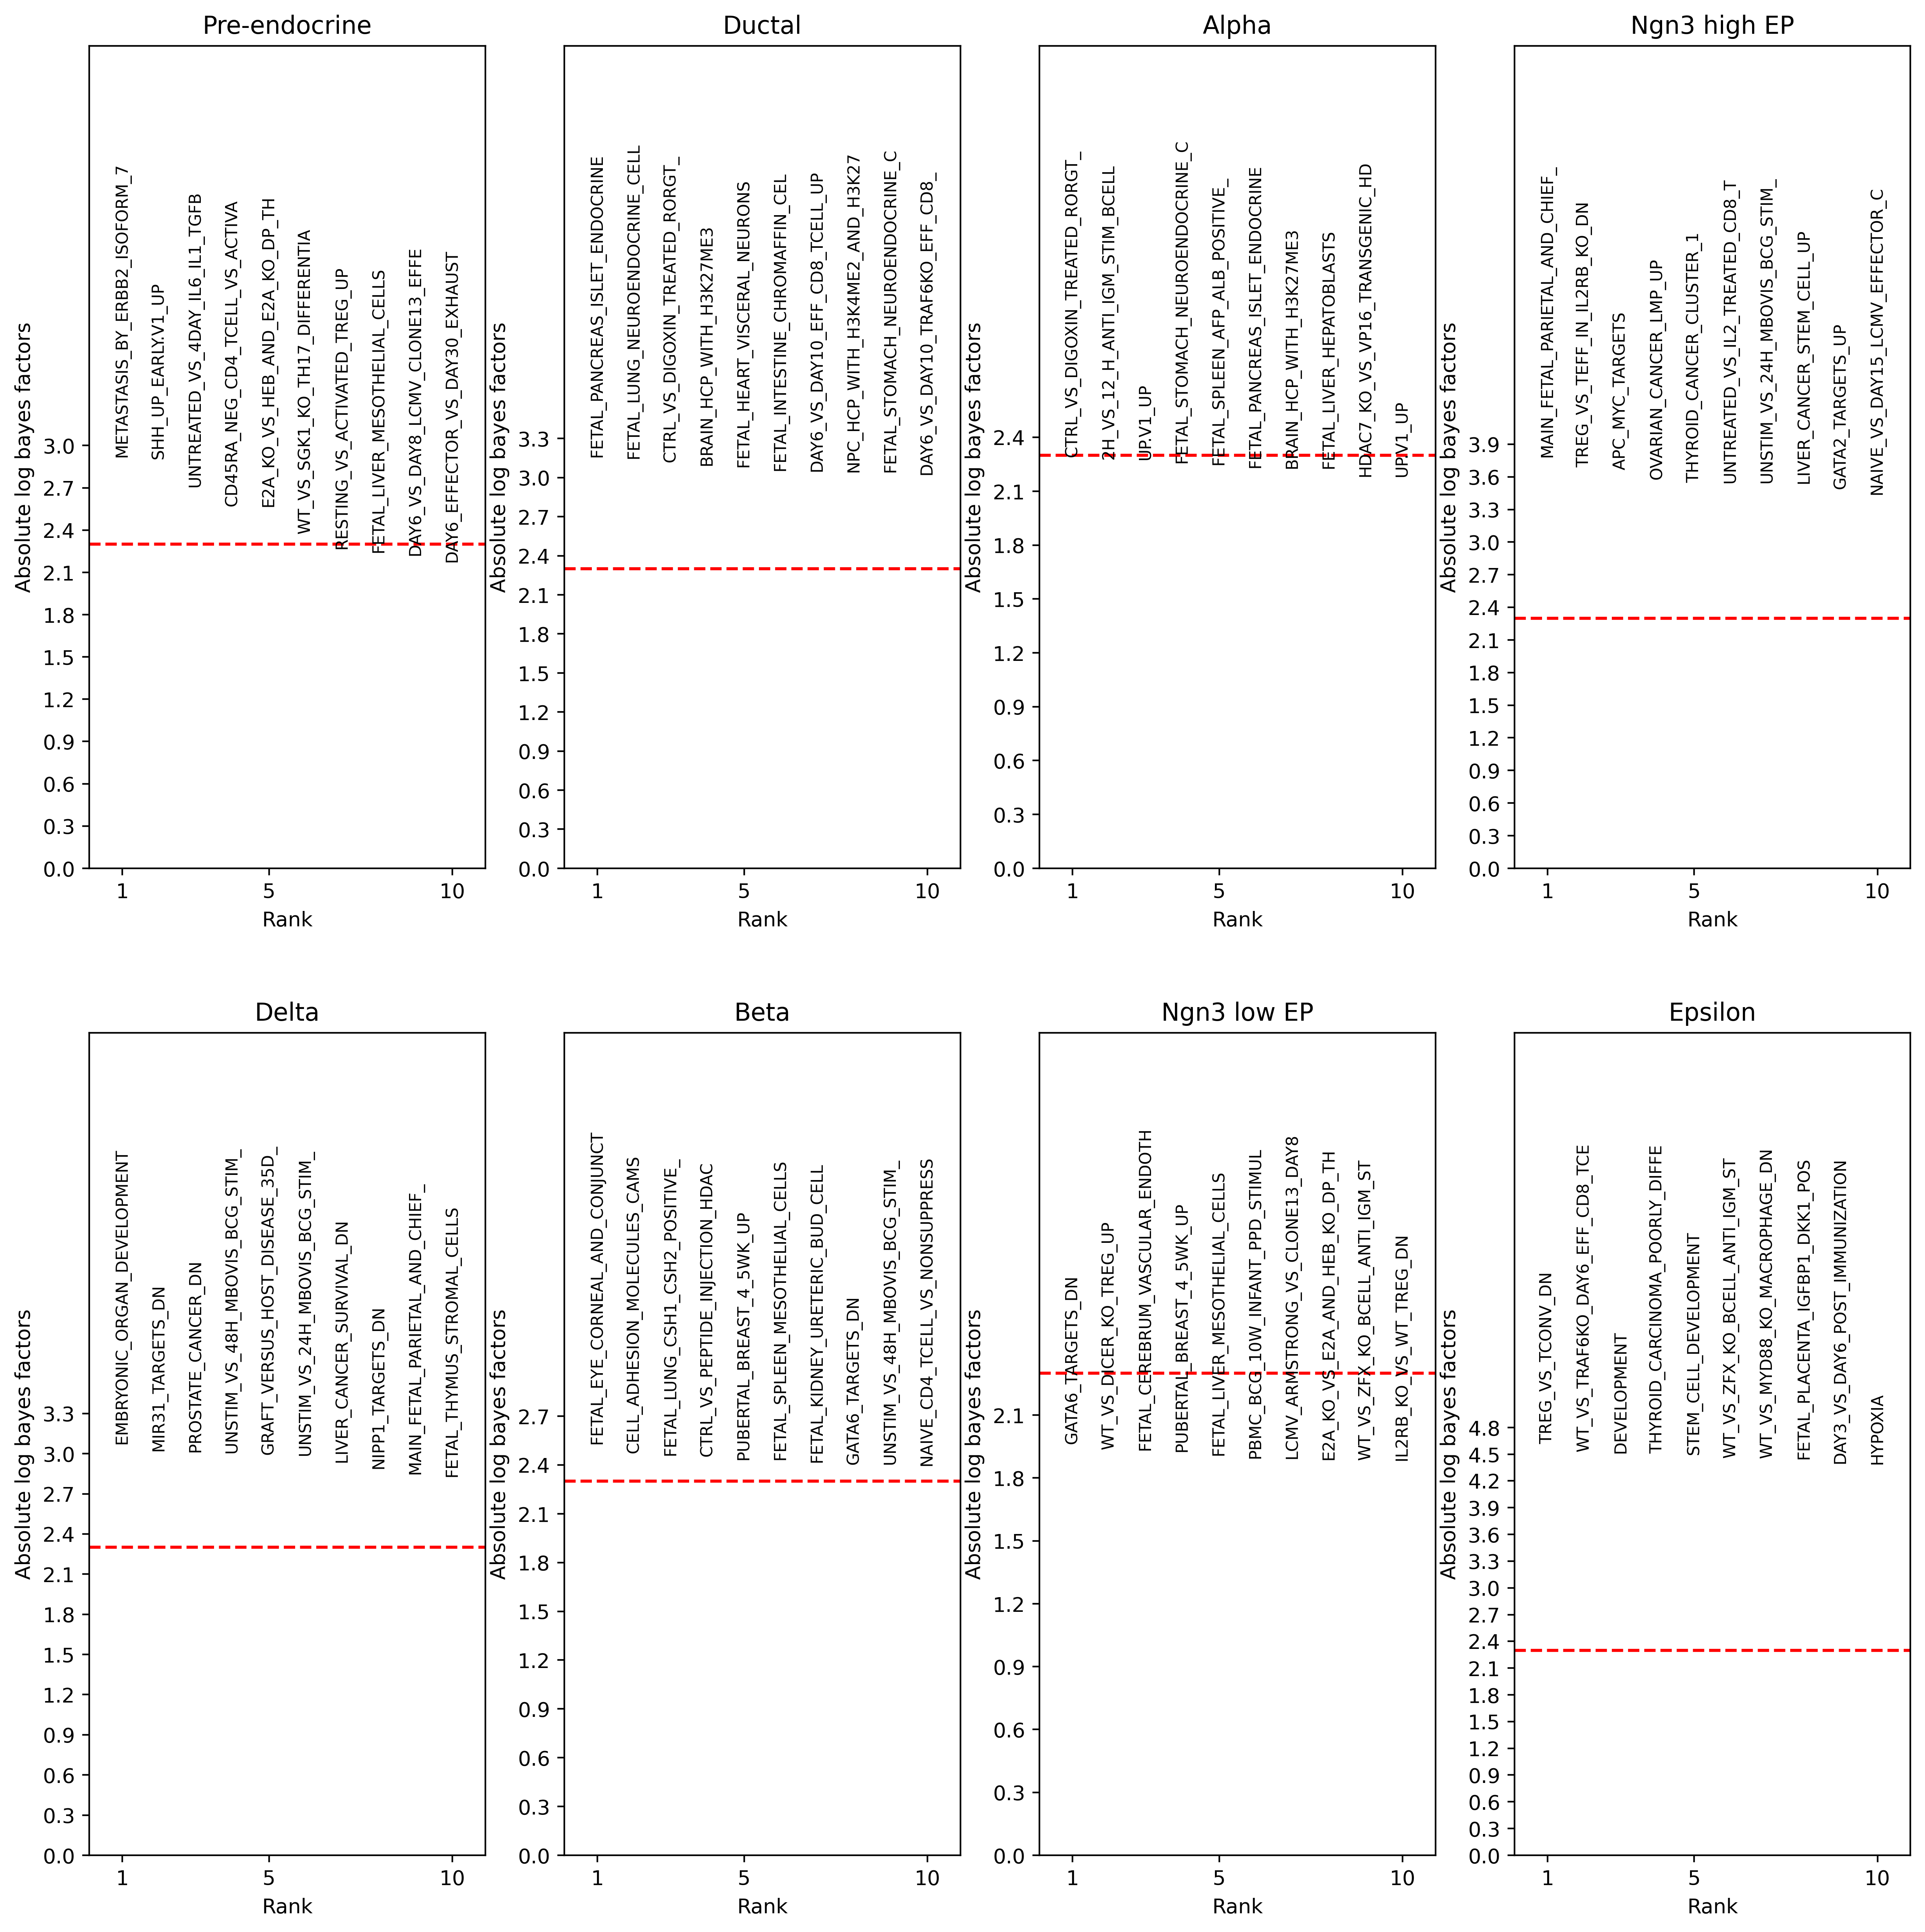

In [15]:
linvi.plotting.plot_abs_bfs(adata, scores_key='bf_scores', n_cols=4, n_points=10, lim_val=2.3, fontsize=8, scale_y=2, yt_step=0.3,
                    title=None, figsize=None, dpi=400)